In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and will be used for training.")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPU detected. Training will use the CPU.")

GPU is available and will be used for training.


In [2]:
from keras_tuner import Hyperband
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

In [3]:
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [6]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

In [7]:
from tensorflow.keras.regularizers import l2


def model_builder(hp):
    model = Sequential()

    # First convolutional layer
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)  # Tune filters
    hp_kernel_1 = hp.Choice('kernel_size_1', values=[3, 5])  # Tune kernel size
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'softmax', 'swish', 'elu'])  # Tune activation function

    model.add(Conv2D(filters=hp_filters_1, 
                     kernel_size=(hp_kernel_1, hp_kernel_1), 
                     activation=None,  # Remove activation temporarily for Batch Normalization
                     padding='same',  # Added padding
                     input_shape=(32, 32, 3), 
                     kernel_regularizer=l2(1e-4)))  # Added L2 regularization
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation(hp_activation))  # Apply activation after Batch Normalization
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Static pooling layer
    model.add(Dropout(0.3))  # Added Dropout after pooling

    # Second convolutional layer
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=256, step=64)
    hp_kernel_2 = hp.Choice('kernel_size_2', values=[3, 5])

    model.add(Conv2D(filters=hp_filters_2, 
                     kernel_size=(hp_kernel_2, hp_kernel_2), 
                     activation=None,  # Remove activation temporarily for Batch Normalization
                     padding='same',  # Added padding
                     kernel_regularizer=l2(1e-4)))  # Added L2 regularization
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation(hp_activation))  # Apply activation after Batch Normalization
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Static pooling layer
    model.add(Dropout(0.3))  # Added Dropout after pooling

    # Third convolutional layer
    hp_filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=64)

    model.add(Conv2D(filters=hp_filters_3, 
                     kernel_size=(3, 3), 
                     activation=None,  # Remove activation temporarily for Batch Normalization
                     padding='same',  # Added padding
                     kernel_regularizer=l2(1e-4)))  # Added L2 regularization
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation(hp_activation))  # Apply activation after Batch Normalization
    model.add(Dropout(0.3))  # Added Dropout for deeper regularization

    # Flatten the feature maps
    model.add(Flatten())

    # Dense layer with tunable units
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_dense_units, activation=None, kernel_regularizer=l2(1e-4)))  # Added L2 regularization
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation(hp_activation))  # Apply activation after Batch Normalization

    # Output layer for 10 classes
    model.add(Dense(10, activation='softmax'))

    # Learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [8]:
import keras_tuner as kt

tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='dir',
    project_name='cifar10_cnn_tuning'
)

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [10]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[stop_early])

Trial 30 Complete [00h 05m 07s]
val_accuracy: 0.1005999967455864

Best val_accuracy So Far: 0.7573999762535095
Total elapsed time: 01h 05m 02s


In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nThe best hyperparameters are:")
print(f"Filters (Layer 1): {best_hps.get('filters_1')}")
print(f"Kernel Size (Layer 1): {best_hps.get('kernel_size_1')}")
print(f"Filters (Layer 2): {best_hps.get('filters_2')}")
print(f"Kernel Size (Layer 2): {best_hps.get('kernel_size_2')}")
print(f"Filters (Layer 3): {best_hps.get('filters_3')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Activation: {best_hps.get('activation')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


The best hyperparameters are:
Filters (Layer 1): 96
Kernel Size (Layer 1): 5
Filters (Layer 2): 128
Kernel Size (Layer 2): 3
Filters (Layer 3): 192
Dense Units: 192
Activation: swish
Learning Rate: 0.0001


In [12]:
model1 = tuner.hypermodel.build(best_hps)
history = model1.fit(X_train, y_train, epochs=50, validation_split=0.2,callbacks=[stop_early])

Epoch 1/50
1125/1125 [==============================] - 25s 21ms/step - loss: 1.5772 - accuracy: 0.4610 - val_loss: 1.6049 - val_accuracy: 0.4802
Epoch 2/50
1125/1125 [==============================] - 23s 21ms/step - loss: 1.2421 - accuracy: 0.5829 - val_loss: 1.6862 - val_accuracy: 0.4582
Epoch 3/50
1125/1125 [==============================] - 23s 20ms/step - loss: 1.0954 - accuracy: 0.6426 - val_loss: 1.3683 - val_accuracy: 0.5849
Epoch 4/50
1125/1125 [==============================] - 23s 20ms/step - loss: 0.9944 - accuracy: 0.6776 - val_loss: 1.2311 - val_accuracy: 0.6072
Epoch 5/50
1125/1125 [==============================] - 23s 20ms/step - loss: 0.9155 - accuracy: 0.7035 - val_loss: 1.4161 - val_accuracy: 0.5709
Epoch 6/50
1125/1125 [==============================] - 22s 20ms/step - loss: 0.8555 - accuracy: 0.7282 - val_loss: 1.0847 - val_accuracy: 0.6631
Epoch 7/50
1125/1125 [==============================] - 23s 20ms/step - loss: 0.8112 - accuracy: 0.7449 - val_loss: 1.1301 -

In [13]:
model1.save('./cifar10_tuned')

INFO:tensorflow:Assets written to: ./cifar10_tuned\assets


INFO:tensorflow:Assets written to: ./cifar10_tuned\assets


In [15]:
import numpy as np

y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true = y_test.flatten()

313/313 [==============================] - 3s 8ms/step


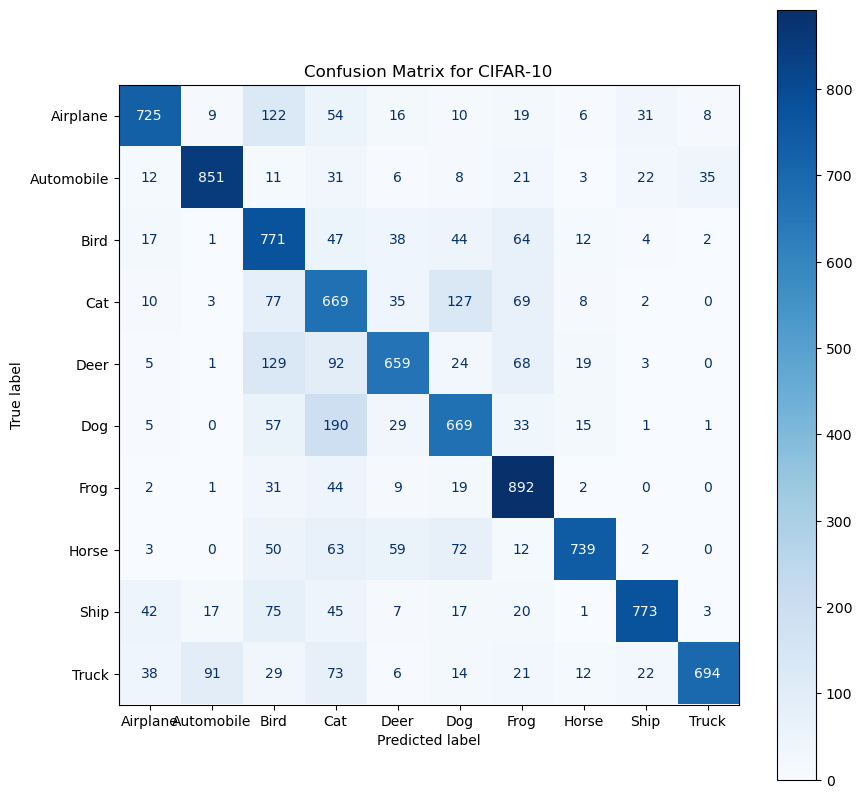

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred_classes)
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for CIFAR-10")
plt.show()

In [17]:
report = classification_report(y_true, y_pred_classes, target_names=labels)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.84      0.72      0.78      1000
  Automobile       0.87      0.85      0.86      1000
        Bird       0.57      0.77      0.66      1000
         Cat       0.51      0.67      0.58      1000
        Deer       0.76      0.66      0.71      1000
         Dog       0.67      0.67      0.67      1000
        Frog       0.73      0.89      0.80      1000
       Horse       0.90      0.74      0.81      1000
        Ship       0.90      0.77      0.83      1000
       Truck       0.93      0.69      0.80      1000

    accuracy                           0.74     10000
   macro avg       0.77      0.74      0.75     10000
weighted avg       0.77      0.74      0.75     10000



In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("accuracy : ", accuracy)
print("precision : ", precision)
print("recall_score : ", recall)
print("f1_score : ", f1)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets